
<h1><center> Deep Q-Learning in PyTorch using Capsule Networks</center></h1>

This notebook will introduce Q-Learning, one of the most famous algorithms in Reinforcement Learning which utilizes Neural Networks as function approximators. All tutorials in the Reinforcement Learning sections require prior knowledge of Deep Neural Networks and it is recommended that you have a look at the notebooks in the Deep Learning section. 


### 1. Import Dependencies

We will use PyTorch and gym (by OpenAI) for our experiments as these are lightweight and easy to program.

In [0]:
# !pip install gym
import math
import json
import random
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
from torch.autograd import Variable

import matplotlib.pyplot as plt
from matplotlib.image import imsave
from google.colab import files

#Use Google Drive
from google.colab import drive
user_name = '/content/drive'
drive_name = '/content/drive/My Drive/Colab Notebooks/Frames-300000'
checkpoint_name = '/content/drive/My Drive/Colab Notebooks/Checkpoints'
drive.mount(user_name, force_remount=True)

#Use GPU
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### 2. Experience Replay Buffer

Almost all Reinforcement Learning methods make use of a Replay Buffer which saves past experiences from a particular episode. Each (state,action,reward,next_state) tuple is stored in the buffer so that the RL algorithm can be trained later when the episode is over.

In [0]:
class ReplayBuffer:
  def __init__(self,capacity): #Initializa Buffer
    self.capacity = capacity
    self.buffer = []
    self.position = 0

  def push(self,state,action,reward,next_state,done): #Push values into buffer
    if len(self.buffer)<self.capacity:
      self.buffer.append(None)
    self.buffer[self.position] = (state,action,reward,next_state,done)
    self.position = (self.position+1)%self.capacity

  def sample(self,batch_size): #Sample values from buffer during training
    batch = random.sample(self.buffer,batch_size)
    state,action,reward,next_state,done = map(np.stack, zip(*batch))
    return state,action,reward,next_state,done

  def __len__(self):
    return len(self.buffer)

### 3. Ornstein-Uhlenbeck Process

Policy Gradient methods require a random process for making the policy explore the game environment. If sufficient exploration is not carried then our agent will not be able to perform all the actions and may fail in cases where it has not encountered a particular state previously. We use the OU process because it is Gaussian, Markovian and temporarily homogenous in nature. 


In [0]:
class OUNoise(object):
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        # Pong- 6,0,5 | Breakout- 4,0,3
        self.action_dim   = 4#action_space.shape[0]
        self.low          = 0#action_space.low
        self.high         = 3#action_space.high
        self.reset()
        
    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu
        
    def evolve_state(self):
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state
    
    def get_action(self, action, t=0):
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, self.low, self.high)

### 4. Actor-Critic Networks

This is where the fun starts! Each Policy Gradient method consists of an Actor Network and a Critic Network. Following are the explanation of the two- 

### 4.1 Actor Network
The Actor Network is responsible for performing the actions during the game. It takes its input as one frame (which is an image) from the game screen and outputs the probabilities for actions. Action corresponding to the highest probability is selected. Actor Networks are often called Policy Networks since they execute the policy which our agent will follow. 

$$ s \rightarrow \pi (a|s,\theta=w)$$

### 4.2 Critic Network
The Critic Network (also called the Value Network) is the one which assesses how good the action was. It takes its input as the state and action performed in that state and outputs the value corresponding to the value function. This value is an indication of how the good the action was and how much it deviates from the ideal action (corresponding to the expected value) in the given state. 

$$ s,a \rightarrow \hat{v}(s,w)$$


In [0]:
# class ValueNetwork(nn.Module): #Replace ANN with CapsNet, concatenate state and action from buffer and take np.argmax from prob tensor after last layer
#   def __init__(self,num_inputs,num_actions,hidden_size,init_w=3e-3): #The Critic Network
#     super(ValueNetwork,self).__init__()
#     self.linear1 = nn.Linear(num_inputs+num_actions,hidden_size)
#     self.linear2 = nn.Linear(hidden_size,hidden_size)
#     self.linear3 = nn.Linear(hidden_size,1)
#     self.linear3.weight.data.uniform_(-init_w,init_w)
#     self.linear3.bias.data.uniform_(-init_w,init_w)

#   def forward(self,state,action): #Forward Pass
#     print(state.shape)
#     print(action.shape)
#     x = torch.cat([state,action],1)
#     x = F.relu(self.linear1(x))
#     x = F.relu(self.linear2(x))
#     x = self.linear3(x)
#     return x

# class PolicyNetwork(nn.Module): #The Actor Network
#     def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3):
#         super(PolicyNetwork, self).__init__()   
#         self.linear1 = nn.Linear(num_inputs, hidden_size)
#         self.linear2 = nn.Linear(hidden_size, hidden_size)
#         self.linear3 = nn.Linear(hidden_size, num_actions)
#         self.linear3.weight.data.uniform_(-init_w, init_w)
#         self.linear3.bias.data.uniform_(-init_w, init_w)
        
#     def forward(self, state): #Forward Pass
#         x = F.relu(self.linear1(state))
#         x = F.relu(self.linear2(x))
#         x = F.tanh(self.linear3(x))
#         return x

#     def get_action(self,state): #Sample Action
#       state = torch.FloatTensor(state).unsqueeze(0).to(device)
#       action = self.forward(state)
#       return action.detach().cpu().numpy()[0,0]


### 5. CapsNet as Actor Network

The architecture here is adopted from Deep Learning tutorials and the DPPG implementation. 

### 5.1 Layers of CapsNet

In [0]:
def squash(x): #Squashing Function
    lengths2 = x.pow(2).sum(dim=2)
    lengths = lengths2.sqrt()
    x = x * (lengths2 / (1 + lengths2) / lengths).view(x.size(0), x.size(1), 1)
    return x


class AgreementRouting(nn.Module): #Dynamic Routing Algorithm
    def __init__(self, input_caps, output_caps, n_iterations):
        super(AgreementRouting, self).__init__()
        self.n_iterations = n_iterations
        self.b = nn.Parameter(torch.zeros((input_caps, output_caps)))

    def forward(self, u_predict):
        batch_size, input_caps, output_caps, output_dim = u_predict.size()
        c = F.softmax(self.b)
        s = (c.unsqueeze(2) * u_predict).sum(dim=1)
        v = squash(s)
        if self.n_iterations > 0:
            b_batch = self.b.expand((batch_size, input_caps, output_caps))
            for r in range(self.n_iterations):
                v = v.unsqueeze(1)
                b_batch = b_batch + (u_predict * v).sum(-1)

                c = F.softmax(b_batch.view(-1, output_caps)).view(-1, input_caps, output_caps, 1)
                s = (c * u_predict).sum(dim=1)
                v = squash(s)
        return v


class CapsLayer(nn.Module): #Digit Capsule Layer
    def __init__(self, input_caps, input_dim, output_caps, output_dim, routing_module):
        super(CapsLayer, self).__init__()
        self.input_dim = input_dim
        self.input_caps = input_caps
        self.output_dim = output_dim
        self.output_caps = output_caps
        self.weights = nn.Parameter(torch.Tensor(input_caps, input_dim, output_caps * output_dim))
        self.routing_module = routing_module
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.input_caps)
        self.weights.data.uniform_(-stdv, stdv)

    def forward(self, caps_output):
        caps_output = caps_output.unsqueeze(2)
        caps_output = caps_output.mean(1)
        caps_output = caps_output.unsqueeze(1)
        u_predict = caps_output.matmul(self.weights)
        u_predict = u_predict.view(u_predict.size(0), self.input_caps, self.output_caps, self.output_dim)
        v = self.routing_module(u_predict)
        return v


class PrimaryCapsLayer(nn.Module): #Primary Capsule Layer
    def __init__(self, input_channels, output_caps, output_dim, kernel_size, stride):
        super(PrimaryCapsLayer, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_caps * output_dim, kernel_size=kernel_size, stride=stride)
        self.input_channels = input_channels
        self.output_caps = output_caps
        self.output_dim = output_dim

    def forward(self, input):
        out = self.conv(input)
        N, C, H, W = out.size()
        out = out.view(N, self.output_caps, self.output_dim, H, W)
        # will output N x OUT_CAPS x OUT_DIM
        out = out.permute(0, 1, 3, 4, 2).contiguous()
        out = out.view(out.size(0), -1, out.size(4))
        out = squash(out)
        return out


### 5.2 CapsNet Architecture

In [0]:
class PolicyNetwork1(nn.Module):
    def __init__(self, n_classes, routing_iterations):
        super(PolicyNetwork1, self).__init__()
        self.conv1 = nn.Conv2d(1, 256, kernel_size=8, stride=4)
        self.primaryCaps = PrimaryCapsLayer(256, 4, 4, kernel_size=4, stride=2)  
        self.num_primaryCaps = 6
        routing_module = AgreementRouting(self.num_primaryCaps, n_classes, routing_iterations)
        self.digitCaps = CapsLayer(self.num_primaryCaps, 4, n_classes, 8, routing_module)
        self.Flatten = nn.Flatten()
        self.Dense1 = nn.Linear(n_classes*8, 512*self.num_primaryCaps*n_classes*8)
        self.Dense2 = nn.Linear(512*self.num_primaryCaps*n_classes*8, n_classes)

    def forward(self, input):
        x = self.conv1(input)
        x = F.relu(x)
        x = self.primaryCaps(x)
        x = self.digitCaps(x)
        x = self.Flatten(x)
        # probs = x.pow(2).sum(dim=2).sqrt()
        x = F.relu(self.Dense1(x))
        x = F.relu(self.Dense2(x))
        x = F.softmax(x)
        return x

    def act(self, state, epsilon):
          if random.random() > epsilon:
            state = torch.FloatTensor(state).unsqueeze(0).to(device)
            action = self.forward(state)
            action  = action.max(1)[1].data[0]
          else:
              action = random.randrange(env.action_space.n)
          return int(action)

### 6. TD Loss



In [0]:
def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)), volatile=True)
    action     = Variable(torch.LongTensor(action))
    reward     = Variable(torch.FloatTensor(reward))
    done       = Variable(torch.FloatTensor(done))

    q_values      = policy_net(state)
    next_q_values = policy_net(next_state)

    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value     = next_q_values.max(1)[0]
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    pol_loss = (q_value - Variable(expected_q_value.data)).pow(2).mean()
        
    optimizer.zero_grad()
    pol_loss.backward()
    optimizer.step()
    
    return_pol_loss = pol_loss.copy()
    
    return return_pol_loss.detach().cpu().numpy()

### 7. Test DQN



In [0]:
def preprocess(I): #Preprocess the Image
  I = I[35:195] # crop
  I = I[::2,::2,0] # downsample by factor of 2
  I[I == 144] = 0 # erase background (background type 1)
  I[I == 109] = 0 # erase background (background type 2)
  I[I != 0] = 1 # everything else (paddles, ball) just set to 1
  I = np.expand_dims(I,axis=0)
  # caps_img = np.swapaxes(I,axis1=0,axis2=2) #shape=(3,160,210)
  return I


env = gym.make('Breakout-v0') #Make the Environment
print('Launching Game...')

state_dim = (1, 80, 80)
action_dim = env.action_space.n
# action_dim = 4 #Number of actions

policy_net = PolicyNetwork1(action_dim,3).to(device)
policy_lr = 1e-3
optimizer = optim.Adam(policy_net.parameters(),lr=policy_lr)

TD_Loss = None
load_model = False #Remember to update the name of json file 
#Load Pre-trained Models from checkpoints
if load_model==True:
  #Load Policy Net
  policy_checkpoint = torch.load(checkpoint_name+'/policy_net.pth.tar') 
  policy_net.load_state_dict(policy_checkpoint['model_state_dict'])
  optimizer.load_state_dict(policy_checkpoint['optimizer_state_dict'])
  TD_Loss = policy_checkpoint['loss']

replay_buffer_size = 100000000
replay_buffer = ReplayBuffer(replay_buffer_size) #Initialize Replay Buffer

num_frames  = 1000 #Change as per storage capacity
rewards     = []
loss = []
batch_size  = 32
gamma = 0.99

episode_reward = 0

epsilon_start = 0.1 #CHANGE THESE!!
epsilon_final = 0.1
epsilon_decay = 30000
epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

print('Training Started...')
print('-'*100)
state = env.reset()

for frame_idx in range(1, num_frames + 1):
  epsilon = epsilon_by_frame(frame_idx)
  prev_state = None
  imsave(drive_name+'/'+str(frame_idx)+'.png', state)
  # files.download(drive_name+'/'+str(frame_idx)+'.png')
  # plt.figure()
  # plt.imshow(state) #Plot frames from the game screen
  state = preprocess(state) #Process the current state as input image
  if prev_state is None:
    prev_state = np.zeros(state_dim)
  prev_state = state
  action = policy_net.act(state, epsilon)
  next_state,reward,done,_ = env.step(action) #Execute action and observe next_state,reward
  n_state = preprocess(next_state) #Porcess next_state as image
  
  replay_buffer.push(state,action,reward,n_state,done) #Push values to buffer
  state = next_state 
  episode_reward += reward #Increment reward
  frame_idx += 1

  if (frame_idx%1000)==0:
    print('Frame-', str(frame_idx), '/', str(num_frames), '| Avg Reward-', avg_reward, '| Loss-', TD_Loss)
    torch.save({'model_state_dict': policy_net.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), 'loss': TD_Loss},checkpoint_name+'/policy_net.pth.tar') #save PolicyNet

  data = {}
  data['reward'] = rewards
  data['loss'] = loss
  # with open(checkpoint_name+'/data-300000.json', 'w') as f: #data+same as frame folder
  #   json.dump(data, f)

  if done:
      state = env.reset()
      episode_reward = 0
      
  if len(replay_buffer) > batch_size:
      TD_Loss = compute_td_loss(batch_size)
      
  rewards.append(episode_reward) #Store rewards
  if len(rewards)>=10:
    avg_reward = sum(rewards[-10:])/10
  if (TD_Loss != None):
    loss.append(TD_Loss)

print('-'*100)
print('Training Completed')


Launching Game...
Training Started...
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  """


torch.Size([32, 4])
torch.Size([32, 1])
torch.Size([32])


AttributeError: ignored

### 8. Plot Results

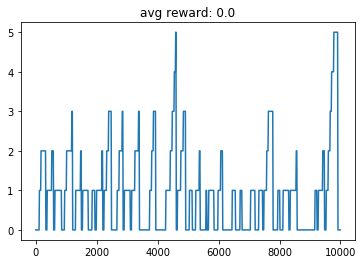

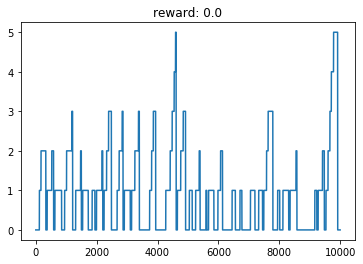

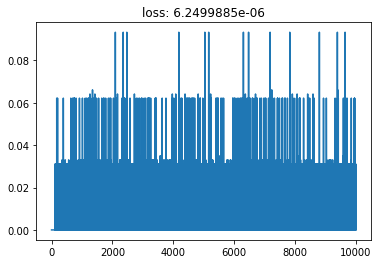

In [0]:
def plot(roll_avg_rewards, rewards, loss): #Plot rewards over episodes
    # # Plot Average Reward
    plt.figure()
    plt.title('avg reward: %s' % (roll_avg_rewards[-1]))
    plt.plot(roll_avg_rewards)
    plt.show()
    # Plot Average Reward
    plt.figure()
    plt.title('reward: %s' % (rewards[-1]))
    plt.plot(rewards)
    plt.show()
    # Plot Average Reward
    plt.figure()
    plt.title('loss: %s' % (loss[-1]))
    plt.plot(loss)
    plt.show()

plot(roll_avg_rewards, rewards, loss)

### 9. Useful Resources

1. DDPG Paper- https://arxiv.org/abs/1509.02971
2. Q-Learning Paper- https://web.stanford.edu/class/psych209/Readings/MnihEtAlHassibis15NatureControlDeepRL.pdf
3. Coursera- https://www.coursera.org/specializations/reinforcement-learning
4. Policy Gradient Paper- http://proceedings.mlr.press/v32/silver14.pdf
5. TowardsDataScience- https://towardsdatascience.com/deep-deterministic-policy-gradients-explained-2d94655a9b7b
6. RL-Adventure (one of my favourite Github repositories)- https://github.com/higgsfield/RL-Adventure-2
